In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.utils.model_zoo as model_zoo
import numpy as np
import sys, time, os, warnings 
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
from torchvision.datasets import Cityscapes

from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image

In [3]:
from albumentations import (Compose,Resize,Normalize)

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
h,w=256,512

transform_train = Compose([ Resize(h,w), 
                Normalize(mean=mean,std=std)])

transform_val = Compose( [ Resize(h,w),
                          Normalize(mean=mean,std=std)])

In [4]:
class myCityscapes(Cityscapes):
    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')

        targets = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            sample= self.transforms(image=np.array(image), mask=np.array(target))
            img = sample['image']
            target = sample['mask'] 
            
        img = to_tensor(img)
        mask = torch.from_numpy(target).type(torch.long)

        return img, mask
    
    def _get_target_suffix(self, mode, target_type):
            
        if target_type == 'instance':
            return '{}_instanceIds.png'.format(mode)
        elif target_type == 'semantic':
            return '{}_labelTrainIds.png'.format(mode)
        elif target_type == 'color':
            return '{}_color.png'.format(mode)
        else:
            return '{}_polygons.json'.format(mode)

In [5]:
train_ds = myCityscapes("./", split='train', mode='fine', target_type='semantic', transforms=transform_train, target_transform=None)
test = myCityscapes("./", split='val', mode='fine', target_type='semantic', transforms=transform_val, target_transform=None)



In [6]:
train , val = train_test_split(train_ds, test_size=0.33, random_state=42)

In [7]:
len(train)

1993

In [8]:
len(val)

982

In [9]:
len(test)

500

In [10]:
#number of classes presented in data
np.random.seed(0)
num_classes=21
COLORS = np.random.randint(0, 2, size=(num_classes+1, 3),dtype="uint8")

In [11]:
def show_img_target(img, target):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        target=target.numpy()
    for ll in range(num_classes):
        mask=(target==ll)
        img=mark_boundaries(np.array(img) , 
                            mask,
                            outline_color=COLORS[ll],
                            color=COLORS[ll])
    plt.imshow(img)

In [12]:
def re_normalize (x, mean = mean, std= std):
    x_r= x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean, std)):
        x_r [c] *= std_c
        x_r [c] += mean_c
    return x_r

In [13]:
#sample from training data
img, mask = train[3]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 256, 512]) torch.FloatTensor tensor(2.6400)
torch.Size([256, 512]) torch.LongTensor tensor(19)


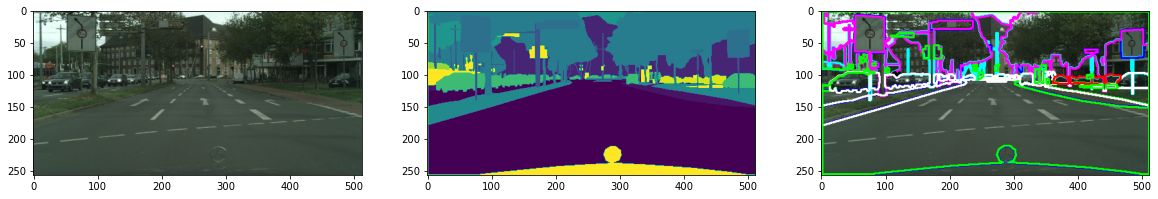

In [14]:
plt.figure(figsize=(20,20))

img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
plt.imshow(mask)

plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

In [15]:
#sample from validation data
img, mask = val[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 256, 512]) torch.FloatTensor tensor(2.6400)
torch.Size([256, 512]) torch.LongTensor tensor(19)


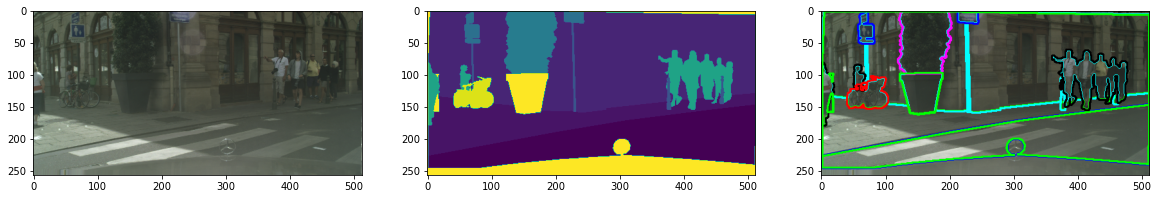

In [16]:
plt.figure(figsize=(20,20))

img_r= re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
plt.imshow(mask)

plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

In [17]:
#defining Dataloaders
from torch.utils.data import DataLoader
train_dl = DataLoader(train, batch_size=2, shuffle=True)
val_dl = DataLoader(val, batch_size=2, shuffle=False)

In [4]:
class Ikshana3glances(nn.Module):
    
  def __init__(self):
    super(Ikshana3glances,self).__init__()
    self.conv11 =  nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride =1,padding=1, dilation=1, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride =1,padding=1, dilation=1, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride =1,padding=1, dilation=1, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True))
    self.conv12 = nn.Sequential(nn.Conv2d(35, 32, kernel_size=3, stride =1,padding=2, dilation=2, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride =1,padding=2, dilation=2, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride =1,padding=2, dilation=2, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True))
    self.conv13 = nn.Sequential(nn.Conv2d(67, 32, kernel_size=3, stride =1,padding=3, dilation=3, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride =1,padding=3, dilation=3, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(32, 32, kernel_size=3, stride =1,padding=3, dilation=3, bias=False),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True))

 
    self.out = nn.Sequential(nn.Conv2d(96, 20, kernel_size=1, stride =1,bias=False))


  def forward(self, x):
    x1  = self.conv11(x) 
    c1  = torch.cat((x,x1),dim=1)
    x1  = self.conv12(c1)
    c1  = torch.cat((c1,x1),dim=1)
    x1  = self.conv13(c1)
    c1  = torch.cat((c1,x1),dim=1)

    #Removing the Imgae from the feature map
    x1  = c1[:,3:,:,:]


    x1 = self.out(x1)

    return x1
    

In [5]:
model = Ikshana3glances()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss(reduction="sum")
from torch import optim
opt = optim.SGD(model.parameters(), lr=1e-6, momentum=0.7,nesterov=True)

In [22]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), None

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [24]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=1e-06


In [25]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    return loss, None

In [26]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    o = open('./Ikshana3glance1.txt','w')
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)

        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr), file=o)

        
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, _ = loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history["val"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            print("Copied best model weights!",file=o)
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            print("Loading best model weights!",file=o)
            model.load_state_dict(best_model_wts)

        print("train loss: %.6f" %(train_loss))
        print("train loss: %.6f" %(train_loss),file=o)
        print("val loss: %.6f" %(val_loss))
        print("val loss: %.6f" %(val_loss),file=o)
        print("-"*10)
        print("-"*10,file=o) 
    model.load_state_dict(best_model_wts)
    o.close()
    return model, loss_history


In [ ]:
start = time.time()

import os
path2models= "./ikshana3glances_"
if not os.path.exists(path2models):
        os.mkdir(path2models)
params_train={
    "num_epochs": 200,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",}
model,loss_hist=train_val(model,params_train)

end = time.time()
o = open('./Ikshana3glance2.txt','w')

print("TIME TOOK {:3.2f}MIN".format((end - start )/60), file=o)

o.close()

print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

In [ ]:
num_epochs=params_train["num_epochs"]
plt.figure(figsize=(30,30))
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [7]:
from torchsummary import summary

In [8]:
summary(model, (3, 256,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 512]             864
       BatchNorm2d-2         [-1, 32, 256, 512]              64
              ReLU-3         [-1, 32, 256, 512]               0
            Conv2d-4         [-1, 32, 256, 512]           9,216
       BatchNorm2d-5         [-1, 32, 256, 512]              64
              ReLU-6         [-1, 32, 256, 512]               0
            Conv2d-7         [-1, 32, 256, 512]           9,216
       BatchNorm2d-8         [-1, 32, 256, 512]              64
              ReLU-9         [-1, 32, 256, 512]               0
           Conv2d-10         [-1, 32, 256, 512]          10,080
      BatchNorm2d-11         [-1, 32, 256, 512]              64
             ReLU-12         [-1, 32, 256, 512]               0
           Conv2d-13         [-1, 32, 256, 512]           9,216
      BatchNorm2d-14         [-1, 32, 2